This notebook build the lens catalogue with Maglim selection

In [1]:
import os
import numpy as np
import healpy as hp
from astropy.io import fits
from astropy import units as u
from astropy.cosmology import FlatwCDM, z_at_value
from astropy import constants as const
import sys
#sys.path.insert(0, "/global/homes/q/qhang/des/")
#import ISW_functions_des as iswf
#from bornraytrace import lensing
#import des_superstructure_profile_functions as dspf
#from orphics import mpi,stats
#import argparse
import pylab as pl

In [13]:
import yaml

In [2]:
simroot = "/global/cfs/cdirs/des/mgatti/Dirac_mocks/runsK/run017/"

In [3]:
# set up cosmology:
run_X = 'K'
run_n = 17
fname=f"/global/homes/m/mgatti/Mass_Mapping/peaks/params_run_1_Niall_{run_X}.txt"
cosmodata = np.loadtxt(fname, delimiter=',')
Om0 = cosmodata[run_n-1,0]
w0 = cosmodata[run_n-1,2]
Ob0 = cosmodata[run_n-1,3]
h0=cosmodata[run_n-1,4]
cosmo = FlatwCDM(H0=h0*100, Om0=Om0,w0=w0,Ob0=Ob0,Tcmb0=2.73)
print(cosmo)

FlatwCDM(H0=70.0 km / (Mpc s), Om0=0.279, w0=-1.0, Tcmb0=2.73 K, Neff=3.04, m_nu=[0. 0. 0.] eV, Ob0=0.046)


In [4]:
sigma8=0.82
ns=0.97

In [5]:
import pyccl as ccl
ccl.gsl_params.LENSING_KERNEL_SPLINE_INTEGRATION = True
cosmo_ccl = ccl.Cosmology(Omega_c = Om0-Ob0, Omega_b = Ob0, h = h0, sigma8 = sigma8, n_s = ns)

In [6]:
# load z_values
z_values=np.loadtxt(simroot + "z_values.txt", delimiter=',')
z_values_index = z_values[:,0]
z_values_bin_max = z_values[:,1]
z_values_bin_min = z_values[:,2]
z_bin_edges = np.append(z_values_bin_max, z_values_bin_min[-1])
z_bin = (z_bin_edges[1:] + z_bin_edges[:-1])/2.

In [7]:
dz=z_values_bin_max-z_values_bin_min

In [8]:
nside=512
lmax=1000
pixwin = hp.pixwin(nside,lmax=lmax)**2

In [9]:
# load mask in nside=512
root="/pscratch/sd/q/qhang/glass_mock/catalog_info/mask/"
mask=hp.read_map(root+"wfd_footprint_nvisitcut_500_nside_128-ebv-0.2-1024.fits")
mask=hp.ud_grade(mask,512)
fsky=np.mean(mask)
print(fsky)
# compute the sky area in terms of armin:
area_pix = hp.nside2pixarea(512, degrees=True)*60**2 # arcmin^2
total_area = np.sum(mask*area_pix)
print(total_area)

0.41963705
62320550.0


In [10]:
#Ngal_lens=np.array([3.93, 6.08, 5.66, 5.71, 3.03])# arcmin ^-2
# above value is for the gold selection, but maglim is much sparse

Ngal_lens=np.array([0.135, 0.117, 0.156, 0.219, 0.2666])

In [14]:
root = '/pscratch/sd/q/qhang/roman-rubin-sims/baselinev3.3/'
packed_stats_maglim = {}
for year in [3]:
    fname=root+f'y{year}/fzb/test-pz-with-i-band-coadd-Y{year}-snr-5.0-lens-meanApsf-theta_eff-maglim.yml'
    with open(fname, "r") as stream:
        packed_stats_maglim[year]=yaml.load(stream,Loader=yaml.Loader)

In [17]:
# load the lens redshift distribution:
# bin 1:
USESHELL={}
USEINDEX={}
NZ_LENS={}
COUNTS={}
MEANZ={}

stats = packed_stats_maglim[3]

for lens_bin in range(5):

    #lens_bin=0
    #root="/pscratch/sd/q/qhang/glass_mock/catalog_info/lsst-y3-fzb/"
    #fin = np.loadtxt(root+f"NofZ-lens-tomo-{lens_bin}-fzb.dat")
    #finzbin = fin[:,0]
    #finzz = (finzbin[1:]+ finzbin[:-1])/2.
    #finnz = fin[:-1,1]
    
    nz = stats["tomo-%d"%(lens_bin+1)]["nztot"]
    d = nz[1,0]-nz[0,0]
    finzbin = np.append(nz[:,0]-d/2., nz[-1,0]+d/2.)
    finzz = nz[:,0]
    finnz = nz[:,1]#/np.sum(nz[:,1])/(nz[1,0]-nz[0,0])
    
    # load n(z)
    N=Ngal_lens[lens_bin]*total_area

    # normalise to nz
    counts = finnz/np.sum(finnz)/(finzbin[1:]-finzbin[:-1]) # notice here dz is constant
    # interpolate the values at z_bin:
    counts = np.interp(z_values_bin_max[::-1], finzz, counts, left=0,right=0)
    # normalise by dz
    counts=counts*(z_values_bin_max[::-1] - z_values_bin_min[::-1])
    counts = counts/np.sum(counts)*N # normalise
    counts = counts[::-1] # this is the number of objects per bin in the same order as the index
    
    # compute mean redshift too:
    meanz=np.sum(z_bin*counts)/np.sum(counts)
    print("N", N, "meanz", meanz)

    # n(z) for lens
    nz_lens=counts/np.sum(counts)/(z_bin_edges[:-1]-z_bin_edges[1:])
    # define which shells are used
    useshell = np.where(counts>0)[0] #(0-99 based)
    useindex = z_values_index[useshell].astype(int)
    #print("The following shells (0-99) are used for lens: ",useshell)
    
    USESHELL[lens_bin]=useshell
    USEINDEX[lens_bin]=useindex
    NZ_LENS[lens_bin]=nz_lens
    COUNTS[lens_bin]=counts
    MEANZ[lens_bin]=meanz

N 8413274.520000001 meanz 0.2693403202813872
N 7291504.584000001 meanz 0.4967827842339575
N 9722006.112 meanz 0.6880201152921854
N 13648200.888 meanz 0.8739331078110674
N 16614659.1632 meanz 1.073869964430464


In [18]:
COUNTS_UD=COUNTS.copy()

(0.0, 3.0)

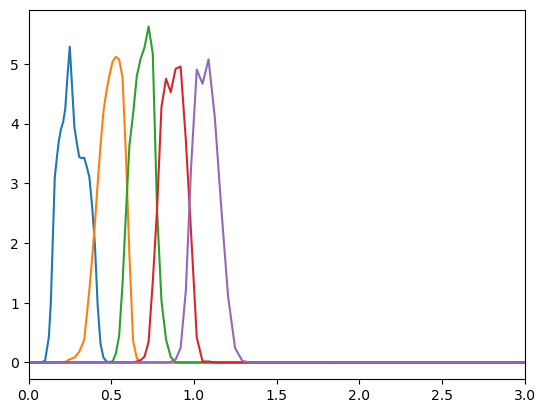

In [19]:
for ii in range(5):
    counts=COUNTS[ii]
    pl.plot(z_bin, counts/sum(counts)/dz)
pl.xlim([0,3])

Uniform, delta map:

In [20]:
# deltamap for uniform case!
# this is just to make the galaxy maps reproducible
savedir="/pscratch/sd/q/qhang/dirac_mock/desc-project285/"

for lens_bin in range(5):
    
    nz_lens = COUNTS[lens_bin]/sum(COUNTS[lens_bin])
    useshell = USESHELL[lens_bin]
    useindex = USEINDEX[lens_bin]

    galmap_inmask = 0
    for ii,index in enumerate(useindex):
        dens = hp.read_map(simroot + f"lens_{index}_512.fits")
        galmap_inmask += dens*nz_lens[useshell][ii]

    # save galmap
    fname=savedir+f"deltamap-lens-maglim-tomo-{lens_bin}-nside-512.fits"
    hp.write_map(fname, galmap_inmask*mask, overwrite=True)
    print("Written: ", fname)

setting the output map dtype to [dtype('float64')]


Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/deltamap-lens-maglim-tomo-0-nside-512.fits


setting the output map dtype to [dtype('float64')]


Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/deltamap-lens-maglim-tomo-1-nside-512.fits


setting the output map dtype to [dtype('float64')]


Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/deltamap-lens-maglim-tomo-2-nside-512.fits


setting the output map dtype to [dtype('float64')]


Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/deltamap-lens-maglim-tomo-3-nside-512.fits


setting the output map dtype to [dtype('float64')]


Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/deltamap-lens-maglim-tomo-4-nside-512.fits


In [21]:
# now compute galaxy number per pixel:
# generate lens galaxy map:
bias=1
Npix = np.sum(mask)
np.random.seed(1234)
# this is just to make the galaxy maps reproducible
savedir="/pscratch/sd/q/qhang/dirac_mock/desc-project285/"

for lens_bin in range(5):
    
    counts = COUNTS[lens_bin]
    useshell = USESHELL[lens_bin]
    useindex = USEINDEX[lens_bin]
    
    Ngal_perpix = counts[useshell]/Npix

    galmap_inmask = 0
    for ii,index in enumerate(useindex):
        dens = hp.read_map(simroot + f"lens_{index}_512.fits")
        exp_Ngal = Ngal_perpix[ii]*(1+bias*dens)
        exp_Ngal = exp_Ngal[mask.astype(bool)]
        # set anything smaller than 0 to 0
        exp_Ngal[exp_Ngal<0]=0
        galmap_inmask += np.random.poisson(lam=exp_Ngal)

    galmap = np.zeros(len(mask))
    galmap[mask.astype(bool)] = galmap_inmask

    # save galmap
    fname=savedir+f"galmap-lens-maglim-tomo-{lens_bin}-nside-512.fits"
    hp.write_map(fname, galmap, overwrite=True)
    print("Written: ", fname)

setting the output map dtype to [dtype('float64')]


Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/galmap-lens-maglim-tomo-0-nside-512.fits


setting the output map dtype to [dtype('float64')]


Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/galmap-lens-maglim-tomo-1-nside-512.fits


setting the output map dtype to [dtype('float64')]


Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/galmap-lens-maglim-tomo-2-nside-512.fits


setting the output map dtype to [dtype('float64')]


Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/galmap-lens-maglim-tomo-3-nside-512.fits


setting the output map dtype to [dtype('float64')]


Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/galmap-lens-maglim-tomo-4-nside-512.fits


In [22]:
galmap={}

savedir="/pscratch/sd/q/qhang/dirac_mock/desc-project285/"
for lens_bin in range(5):
    fname=savedir+f"galmap-lens-maglim-tomo-{lens_bin}-nside-512.fits"
    galmap[lens_bin]=hp.read_map(fname)

In [25]:
clgg = np.zeros((1001, 5))
root="/pscratch/sd/q/qhang/dirac_mock/desc-project285/"
for ii in range(5):
    # now let's check fitting ccl theory / camb theory!
    delta = (galmap[ii]/(sum(galmap[ii])/sum(mask))-1)*mask
    clgg[:,ii] = hp.anafast(delta,lmax=1000)/fsky

fname = root+"clgg-maglim-pseudo-cl-w-fsky-nside-512.txt"
np.savetxt(fname, clgg)

In [26]:
root="/pscratch/sd/q/qhang/dirac_mock/desc-project285/"
fname = root+"clgg-maglim-pseudo-cl-w-fsky-nside-512.txt"  
clgg = np.loadtxt(fname)

In [23]:
shotnoise=np.zeros(5)
for ii in range(5):
    shotnoise[ii]=4*np.pi*fsky/sum(galmap[ii])
    
print(shotnoise)

[6.24662293e-07 7.24234555e-07 5.41624902e-07 3.86396288e-07
 3.17436649e-07]


In [24]:
root="/pscratch/sd/q/qhang/glass_mock/catalog_info/lsst-y3-fzb/"
ell=np.arange(1,3*nside)
clth = np.zeros((3*nside,5))
for lens_bin in range(5):
    
    #fin = np.loadtxt(root+f"NofZ-lens-tomo-{lens_bin}-fzb.dat")
    #finzbin = fin[:,0]
    #finzz = (finzbin[1:]+ finzbin[:-1])/2.
    #finnz = fin[:-1,1]
    
    # try ccl:
    counts = COUNTS[lens_bin]
    nz = counts/np.sum(counts)/dz
    clu1 = ccl.NumberCountsTracer(cosmo_ccl, has_rsd=False, dndz=(z_bin[::-1], nz[::-1]), 
                                          bias=(z_bin[::-1],np.ones(len(finzz))))

    tmp=ccl.angular_cl(cosmo_ccl, clu1, clu1, ell)
    clth[:,lens_bin] = np.append(0, tmp)
    
root="/pscratch/sd/q/qhang/dirac_mock/desc-project285/"
fname = root+"clgg-maglim-theory-z_bin-nside-512.txt"
np.savetxt(fname, clth)

In [28]:
root="/pscratch/sd/q/qhang/dirac_mock/desc-project285/"
fname = root+"clgg-maglim-theory-z_bin-nside-512.txt"    
clth = np.loadtxt(fname)

In [29]:
# modify theory:
clth_obs = np.zeros((1001,5))
for ii in range(5):
    clth_obs[:,ii] = (clth[:1001,ii]*pixwin)#+shotnoise[ii]
    #clth_obs[:,ii] = (clth[:1001,ii]+shotnoise[ii])*pixwin

In [30]:
def fit_shotnoise(param, data, model, pshot):
    return np.sum(abs(data/(model+param*pshot)-1))

In [31]:
from scipy.optimize import minimize

new_shot=[]
for ii in range(5):
    x0=1.2
    res = minimize(fit_shotnoise, x0, args=(clgg[600:,ii], clth_obs[600:,ii], shotnoise[ii]), tol=1e-10)
    new_shot.append(res.x[0]*shotnoise[ii])
    print(res.x[0])
print(new_shot)

for ii in range(5):
    ratio = clgg[:,ii]/(clth_obs[:,ii]+new_shot[ii])
    ratio[0:2] = 0
    mean = np.mean(ratio)
    std = np.std(ratio)/np.sqrt(1000)
    print(mean, std)

1.0327820677296966
1.0191833121851632
1.0314668521154968
1.0205322303621482
1.0235745913226222
[6.451400144212375e-07, 7.381277724137032e-07, 5.58668132340528e-07, 3.943298655590948e-07, 3.249200879550556e-07]
1.0014325863605507 0.0035917054489389547
0.9967039426707545 0.0028984088878660206
1.000804426841662 0.004631938646277299
1.0009702051622213 0.004143079962625714
1.0005986403899685 0.00450956468067989


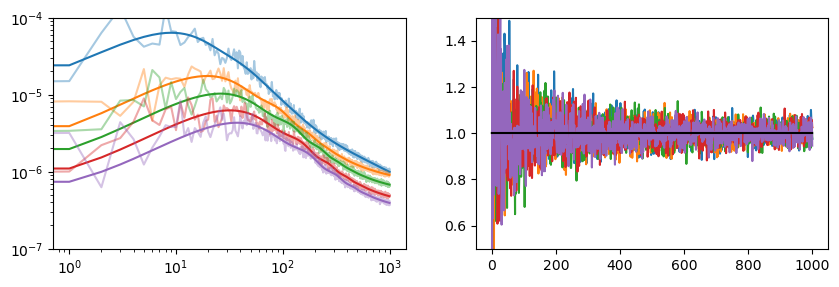

In [32]:
# plot all of them:
fig,axarr=pl.subplots(1,2,figsize=[10,3])
for ii in range(5):
    pl.sca(axarr[0])
    
    pl.loglog(clgg[:,ii],alpha=0.4)
    pl.loglog(clth_obs[:,ii]+new_shot[ii],color=f'C{ii}')
    pl.ylim([1e-7,1e-4])
    
    pl.sca(axarr[1])
    pl.plot(clgg[:,ii]/(clth_obs[:,ii]+new_shot[ii]))
    #pl.plot(cls["W1xW1"])
    pl.plot([1,1000],[1,1],'k-')
    pl.ylim([0.5,1.5])

# VD case:

In [33]:
# load depth map and depth bins:
savedir = "/pscratch/sd/q/qhang/roman-rubin-sims/baselinev3.3/y3/"
sys_info = savedir + "ExgalM5-i-qtl-mean-weights.txt"
fin=np.loadtxt(sys_info)
qtl=fin[:,0]
nquantiles=len(qtl)-1
qweights=fin[:-1,2]
print(qtl)

# load depth map:
root="/pscratch/sd/q/qhang/rubin_baseline_v3.3/MAF-3year/"
fname=root+"baseline_v3_3_10yrs_ExgalM5_i_and_nightlt1095_HEAL.fits"
depth_map = hp.ud_grade(hp.read_map(fname),512)*mask

# pixels:
depth_bin_pixels={}
for ii in range(nquantiles):
    depth_bin_pixels[ii]=np.where((depth_map>=qtl[ii])&(depth_map<qtl[ii+1]))[0]

[24.45635701 25.58412269 25.68054968 25.74725094 25.80403718 25.85731518
 25.90701103 25.9576563  26.02081685 26.11157773 27.36975508]


In [34]:
# load evaluation results:
lens_y3_armin2 = np.array([0.135, 0.117, 0.156, 0.219, 0.2666])

Ngal_lens_vd={}
for ii in range(5):
    N_galaxies=np.zeros(nquantiles)
    for q in range(nquantiles):
        nz = packed_stats_maglim[3]["tomo-%d"%(ii+1)]["nz"][q]
        N_galaxies[q]=np.sum(nz[:,1])
    Nmean = sum(N_galaxies*qweights)
    # show
    Ngal_lens_vd[ii]=N_galaxies/Nmean*lens_y3_armin2[ii]
print(Ngal_lens_vd)

{0: array([0.12126456, 0.12891988, 0.12814325, 0.13158259, 0.13413436,
       0.13690803, 0.13679708, 0.14123494, 0.14445239, 0.14656038]), 1: array([0.10826274, 0.11194971, 0.11172625, 0.11552495, 0.11552495,
       0.11731257, 0.11809465, 0.12133471, 0.12301061, 0.1272562 ]), 2: array([0.13919423, 0.14674224, 0.14973925, 0.15429025, 0.15584426,
       0.15673226, 0.15884126, 0.16150527, 0.16605627, 0.17105128]), 3: array([0.19692826, 0.20315172, 0.20826386, 0.21237579, 0.21570979,
       0.22215552, 0.22171099, 0.22904579, 0.23604719, 0.24460446]), 4: array([0.23501541, 0.24826356, 0.25538861, 0.26184569, 0.26407227,
       0.26963871, 0.27130865, 0.28132825, 0.28644939, 0.29268381])}


In [35]:
# load nofz and interpolation

USESHELL={}
USEINDEX={}
NZ_LENS={}
COUNTS={}
MEANZ={}

#root="/pscratch/sd/q/qhang/glass_mock/catalog_info/lsst-y3-fzb/"

for lens_bin in range(5):
    
    USESHELL[lens_bin]={}
    USEINDEX[lens_bin]={}
    NZ_LENS[lens_bin]={}
    COUNTS[lens_bin]={}
    MEANZ[lens_bin]={}
    
    for depth_bin in range(10):

        #fin = np.loadtxt(root+f"NofZ-lens-tomo-{lens_bin}-VD-{depth_bin}-fzb.dat")
        #finzbin = fin[:,0]
        #finzz = (finzbin[1:]+ finzbin[:-1])/2.
        #finnz = fin[:-1,1]
        
        nz = stats["tomo-%d"%(lens_bin+1)]["nz"][depth_bin]
        d = nz[1,0]-nz[0,0]
        finzbin = np.append(nz[:,0]-d/2., nz[-1,0]+d/2.)
        finzz = nz[:,0]
        finnz = nz[:,1]
        N=Ngal_lens_vd[lens_bin][depth_bin]*total_area

        # normalise to nz
        counts = finnz/np.sum(finnz)/(finzbin[1:]-finzbin[:-1]) # notice here dz is constant
        # interpolate the values at z_bin:
        counts = np.interp(z_values_bin_max[::-1], finzz, counts, left=0,right=0)
        # normalise by dz
        counts=counts*(z_values_bin_max[::-1] - z_values_bin_min[::-1])
        counts = counts/np.sum(counts)*N # normalise
        counts = counts[::-1] # this is the number of objects per bin in the same order as the index

        # compute mean redshift too:
        meanz=np.sum(z_bin*counts)/np.sum(counts)
        #print("N", N, "meanz", meanz)

        # n(z) for lens
        nz_lens=counts/np.sum(counts)/(z_bin_edges[:-1]-z_bin_edges[1:])
        # define which shells are used
        useshell = np.where(counts>0)[0] #(0-99 based)
        useindex = z_values_index[useshell].astype(int)
        #print("The following shells (0-99) are used for lens: ",useshell)

        USESHELL[lens_bin][depth_bin]=useshell
        USEINDEX[lens_bin][depth_bin]=useindex
        NZ_LENS[lens_bin][depth_bin]=nz_lens
        COUNTS[lens_bin][depth_bin]=counts
        MEANZ[lens_bin][depth_bin]=meanz

meanz 0.2615195657296057 Ngal 7557274.619074645
meanz 0.26508089286322506 Ngal 8034357.829244956
meanz 0.26579960823477944 Ngal 7985958.083285648
meanz 0.2685173837463443 Ngal 8200299.815391151
meanz 0.2690041690047402 Ngal 8359327.552114591
meanz 0.27062208403364624 Ngal 8532183.787683545
meanz 0.27067116389830886 Ngal 8525269.53826079
meanz 0.27260610200345875 Ngal 8801839.51517111
meanz 0.2729393956267939 Ngal 9002352.748431098
meanz 0.2745607819558618 Ngal 9133723.487463508
mean N 8413258.697612103


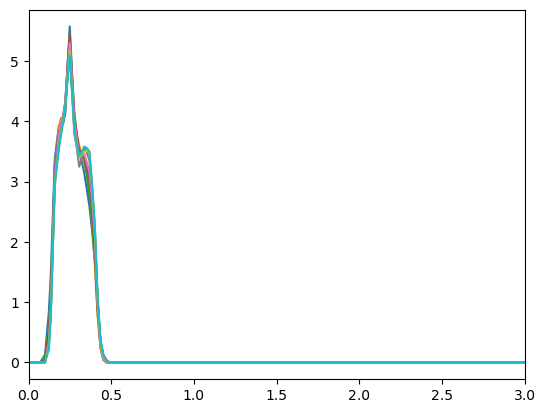

In [38]:
# check:
lens_bin = 0
for ii in range(10):
    pl.plot(z_bin, NZ_LENS[lens_bin][ii])
pl.xlim([0,3])

meanN = 0
for ii in range(10):
    print("meanz", MEANZ[lens_bin][ii], "Ngal", sum(COUNTS[lens_bin][ii]))
    meanN += sum(COUNTS[lens_bin][ii])/10
print("mean N", meanN)

In [39]:
# density map without noise:
savedir="/pscratch/sd/q/qhang/dirac_mock/desc-project285/"
root="/pscratch/sd/q/qhang/dirac_mock/desc-project285/"

# this is the delta map with nz effects
delta_mod={}# this is the modification map we first construct these maps for each bin

for ii in range(5):
    frac = Ngal_lens_vd[ii]/lens_y3_armin2[ii]
    delta_mod[ii]=np.zeros(len(mask))
    for depth_bin in range(10):
        pixels = depth_bin_pixels[depth_bin]
        delta_mod[ii][pixels]=(frac[depth_bin]-1)

In [40]:
delta_map={}
for ii in range(5):
    delta_map[ii]=np.zeros(len(mask))

for shelli in range(16,100):
    
    if shelli%20==0:
        print(f"Doing shell = {shelli}...")
    
    dens = hp.read_map(simroot + f"lens_{shelli+1}_512.fits")#1-100
    
    for ii in range(5):
        for depth_bin in range(10):
            useshell = USESHELL[ii][depth_bin]
            nz_lens = COUNTS[ii][depth_bin]/sum(COUNTS[ii][depth_bin]) # notice here we don't want the dz factor!
            pixels = depth_bin_pixels[depth_bin]
        
            if shelli in useshell:
                delta_map[ii][pixels] += dens[pixels]*nz_lens[shelli]

Doing shell = 20...
Doing shell = 40...
Doing shell = 60...
Doing shell = 80...


In [41]:
# save map
root="/pscratch/sd/q/qhang/dirac_mock/desc-project285/"
for ii in range(5):
    fname=savedir+f"deltamap-vd-nzonly-lens-maglim-tomo-{ii}-nside-512.fits"
    hp.write_map(fname, delta_map[ii], overwrite=True)
    print("Written: ", fname)
    
    fname=savedir+f"deltamap-vd-lens-maglim-tomo-{ii}-nside-512.fits"
    hp.write_map(fname, delta_map[ii]+delta_mod[ii], overwrite=True)
    print("Written: ", fname)

setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]


Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/deltamap-vd-nzonly-lens-maglim-tomo-0-nside-512.fits
Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/deltamap-vd-lens-maglim-tomo-0-nside-512.fits
Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/deltamap-vd-nzonly-lens-maglim-tomo-1-nside-512.fits


setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]


Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/deltamap-vd-lens-maglim-tomo-1-nside-512.fits
Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/deltamap-vd-nzonly-lens-maglim-tomo-2-nside-512.fits
Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/deltamap-vd-lens-maglim-tomo-2-nside-512.fits


setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]


Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/deltamap-vd-nzonly-lens-maglim-tomo-3-nside-512.fits
Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/deltamap-vd-lens-maglim-tomo-3-nside-512.fits
Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/deltamap-vd-nzonly-lens-maglim-tomo-4-nside-512.fits
Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/deltamap-vd-lens-maglim-tomo-4-nside-512.fits


In [42]:
# galaxy map:

# now compute galaxy number per pixel:
# generate lens galaxy map:
bias=1
Npix = np.sum(mask)
np.random.seed(1234)
# this is just to make the galaxy maps reproducible
savedir="/pscratch/sd/q/qhang/dirac_mock/desc-project285/"

for lens_bin in range(5):

    counts = COUNTS[lens_bin]
    useshell = USESHELL[lens_bin]
    useindex = USEINDEX[lens_bin]
    galmap = np.zeros(len(mask))
    
    for depth_bin in range(10):
        
        for ii,index in enumerate(useindex[depth_bin]):
            dens = hp.read_map(simroot + f"lens_{index}_512.fits")
            pixels = depth_bin_pixels[depth_bin]
            
            Ngal_perpix = counts[depth_bin]
            Ngal_perpix = Ngal_perpix[useshell[depth_bin]]/Npix
            
            exp_Ngal = Ngal_perpix[ii]*(1+bias*dens[pixels])
            #exp_Ngal = exp_Ngal[mask.astype(bool)]
            # set anything smaller than 0 to 0
            #exp_Ngal[exp_Ngal<0]=0
            galmap[pixels] += np.random.poisson(lam=exp_Ngal)

    # save galmap
    fname=savedir+f"galmap-vd-lens-maglim-tomo-{lens_bin}-nside-512.fits"
    hp.write_map(fname, galmap, overwrite=True)
    print("Written: ", fname)

setting the output map dtype to [dtype('float64')]


Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/galmap-vd-lens-maglim-tomo-0-nside-512.fits


setting the output map dtype to [dtype('float64')]


Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/galmap-vd-lens-maglim-tomo-1-nside-512.fits


setting the output map dtype to [dtype('float64')]


Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/galmap-vd-lens-maglim-tomo-2-nside-512.fits


setting the output map dtype to [dtype('float64')]


Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/galmap-vd-lens-maglim-tomo-3-nside-512.fits


setting the output map dtype to [dtype('float64')]


Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/galmap-vd-lens-maglim-tomo-4-nside-512.fits


# compute clgg data vector using namaster

# Check results:

In [43]:
root="/pscratch/sd/q/qhang/dirac_mock/desc-project285/"
ell=np.loadtxt(root+"effective_ells.txt")
bw=np.load(root+"wb-clgg-binning-20-2000-nell-20-log.npy")

In [44]:
def convolve_bandpower(bw, cl_th):
    # convolve with band power:
    usebw=bw[0,:,0,:]
    L=len(cl_th)
    L2=usebw.shape[1]
    if L2>=L: 
        cl_th_binned=np.dot(cl_th, usebw[:,:L].T)
    else:
        cl_th_binned=np.dot(cl_th[:L2], usebw.T)
    return cl_th_binned

In [45]:
clgg_binned_un = np.loadtxt(root+"data-nmt-clgg-maglim-512-binning-20-2000.txt")
clgg_binned_vd = np.loadtxt(root+"data-nmt-clgg-vd-maglim-512-binning-20-2000.txt")

# covmat
clgg_cov = {}
for ii in range(5):
    fname = root+f"cov-nmt-clgg-maglim-tomo-{ii}-512-binning-20-2000.txt"
    clgg_cov[ii]=np.loadtxt(fname)
    
# theory - binned:
clgg_theory = np.loadtxt(root+"clgg-maglim-theory-z_bin-nside-512.txt")
# add pixwin and shotnoise
pshot = np.array([6.451400144212375e-07, 7.381277724137032e-07, 5.58668132340528e-07, 
                  3.943298655590948e-07, 3.249200879550556e-07])
pixwin=hp.pixwin(nside,lmax=3*nside-1)**2
clgg_theory_binned = []
for ii in range(5):
    tmp=(clgg_theory[:,ii]*pixwin)+pshot[ii]
    # binned version:
    clgg_theory_binned.append(convolve_bandpower(bw, tmp))

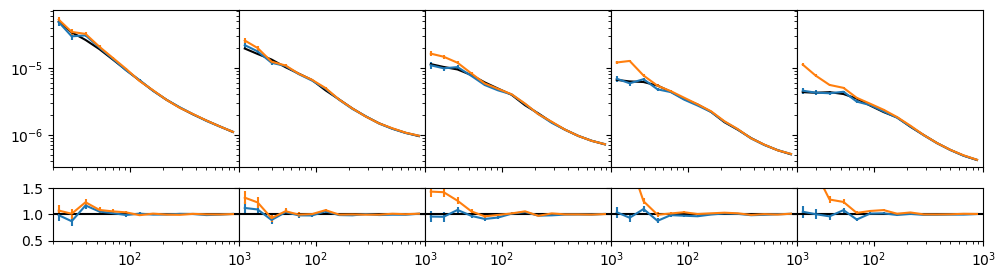

In [46]:
fig,axarr=pl.subplots(2,5,figsize=[12,3],sharey='row',sharex=True,
                     gridspec_kw={'height_ratios': [3, 1]})
for ii in range(5):
    pl.sca(axarr[0,ii])
    yerr=np.sqrt(np.diag(clgg_cov[ii]))
    pl.errorbar(ell, clgg_binned_un[ii,:], yerr=yerr)
    pl.errorbar(ell, clgg_binned_vd[ii,:], yerr=yerr)
    pl.plot(ell, clgg_theory_binned[ii], 'k-')
    pl.xscale("log")
    pl.yscale("log")
    
    pl.sca(axarr[1,ii])
    ratio=clgg_binned_un[ii,:]/clgg_theory_binned[ii]
    err=yerr/clgg_theory_binned[ii]
    pl.errorbar(ell,ratio,yerr=err)
    
    ratio=clgg_binned_vd[ii,:]/clgg_theory_binned[ii]
    pl.errorbar(ell,ratio,yerr=err)
    
    pl.plot([20,1000],[1,1],'k-')
    pl.ylim([0.5,1.5])
pl.xlim([20,1000])
pl.subplots_adjust(wspace=0)

# chi square

In [47]:
# noisey clgg:
ellmax=[265.9807349941148, 403.1155966170281, 539.8220627877016, 653.0018484000559, 756.7049307487994]
pshot = np.array([6.451400144212375e-07, 7.381277724137032e-07, 5.58668132340528e-07, 
                  3.943298655590948e-07, 3.249200879550556e-07])
pixwin=hp.pixwin(nside,lmax=3*nside-1)**2

#pshot[0]*=1.05
#pshot[1]*=1.01
#pshot[2]*=1.04
#pshot[3]*=1.02
#pshot[4]*=1.02

clgg_binned_un = np.loadtxt(root+"data-nmt-clgg-maglim-512-binning-20-2000.txt")
clgg_binned_vd = np.loadtxt(root+"data-nmt-clgg-vd-maglim-512-binning-20-2000.txt")
clgg_theory = np.loadtxt(root+"clgg-maglim-theory-z_bin-nside-512.txt")

# covmat
chi_sq_1=np.zeros(5)
chi_sq_2=np.zeros(5)
for ii in range(5):
    ind_scale = (ell<ellmax[ii])#&(ell>50)
    print("dof: ", sum(ind_scale))
    
    data1 = clgg_binned_un[ii, ind_scale]
    data2 = clgg_binned_vd[ii, ind_scale]
    
    fname = root+f"cov-nmt-clgg-maglim-tomo-{ii}-512-binning-20-2000.txt"
    covmat=np.loadtxt(fname)#/fsky
    covmat=covmat[ind_scale,:]
    covmat=covmat[:,ind_scale]
    invcov = np.linalg.inv(covmat)
    
    tmp=(clgg_theory[:,ii]*pixwin)+pshot[ii]
    theory = convolve_bandpower(bw, tmp)
    theory = theory[ind_scale]#*factor[ii]
    
    vec=data1-theory
    chi_sq_1[ii]=np.dot(vec,np.dot(vec,invcov))
    
    vec=data2-theory
    chi_sq_2[ii]=np.dot(vec,np.dot(vec,invcov))
print("chi sq uniform: ", chi_sq_1/sum(ind_scale))
print("chi sq vd: ", chi_sq_2/sum(ind_scale))

dof:  9
dof:  11
dof:  12
dof:  12
dof:  13
chi sq uniform:  [0.83808058 1.27341863 2.23674703 1.97885803 1.20546043]
chi sq vd:  [ 1.76319215  2.24202239  6.92250783 21.21629712 32.52148546]
